# Project 2: inverse kinematics and resolved rate control

In this project, we will implement an inverse kinematics algorithm and controllers for the Kuka iiwa 14 robot using the results from Project 1.

## Instructions
* Answer all questions in the notebook
* You will need to submit on Brightspace: 
    1. the code you wrote to answer the questions in a Jupyter Notebook. The code should be runnable as is.
    2. a 2-3 pages report in pdf format (pdf only) detailing the methodology you followed to answer the questions as well as answers to the questions that require a typeset answer. You may add the plots in the report (does not count for the page limit) or in the Jupyter notebook.

As a reminder, the [Kuka iiwa 14 robot](https://www.kuka.com/en-us/products/robotics-systems/industrial-robots/lbr-iiwa) has 7 revolute joints and its kinematics is described in the picture below:

![](./kuka_kinematics.png "Kuka iiwa 14 Kinematic Model")

# Setup

Run the cell below only once when resetting the runtime in Colab - this will not do anything when running on a local Jupyter Notebook.

In [1]:
## check if we are in Google Colab
try:
    import google.colab
    RUNNING_IN_COLAB = True
    print('detected Colab - setting up environment')
    # then we need to install the conda environment
    try:
        import condacolab
        condacolab.check()
    except:
        !pip install -q condacolab
        import condacolab
        condacolab.install()
except:
    RUNNING_IN_COLAB = False

In [2]:
# after installing condalab, the runtime restarts
# -> need to check for colab env once more here
try:
    import google.colab
    RUNNING_IN_COLAB = True
except Exception as e:
    RUNNING_IN_COLAB = False

if RUNNING_IN_COLAB:
    try:
        # Check if packages are installed or not. If not, install them.
        import pinocchio
    except:
        # Install pinocchio, meschat-python 
        !conda install pinocchio meshcat-python
       
    # get the class repo - first check if it exists
    import os, sys
    if not os.path.isdir('/content/ROB6003/Project2'):
      print('cloning LAB repository')
      os.chdir('/content')
      !git clone https://github.com/righetti/ROB6003.git
      print('cloning done')
    else:
      print('lab repos was found, skipping cloning')
    print('done configuring for Colab')
    sys.path.append('/content/ROB6003/Project2/')
    os.chdir('/content/ROB6003/Project2/')
    print('done adding system path and changing directory.')


# Starting the visualization environment

The following code will start a visualization environment (click on the printed address to see the robot)

You need to run this only ONCE. Each time you run this cell you will get a new display environment (so you need to close the previous one!)

This should work out of the box on Google Colab and you local Jupyter Notebook (make sure you have installed the right libraries in your local computer if you do not use Colab).

In [3]:
import numpy as np
import robot_visualizer
import time

import matplotlib.pyplot as plt

robot_visualizer.start_robot_visualizer()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7000/static/
You should see the Kuka iiwa robot now when going to this page: http://127.0.0.1:7000/static/


# Displaying an arbitrary configuration

As in the previous project, you can use the following function to display arbitrary configurations of the robot

In [14]:
# here we display an arbitrary configuration of the robot
q = np.array([1, 1, -1, -1, 1, 1, 1])
print(f'we show the configuration for the angles {q}')
robot_visualizer.display_robot(q)

we show the configuration for the angles [ 1  1 -1 -1  1  1  1]


## Question 1: inverse kinematics
* Write a function ``compute_IK_position`` that gets a desired end-effector 3D position (in spatial frame) and returns a vector of joint angles that solves the inverse kinematics problem
* The file ``desired_end_effector_positions.npy`` contains a sequence of 10 desired end-effector positions. For all the positions attainable by the robot, compute an inverse kinematics solution. For the positions for which an inverse kinematics solution does not exist, what is the issue and how close can you get the end-effector to the desired position?
* Write a function ``compute_IK_position_nullspace`` that solves the inverse kinematics problem and additionally uses joint redundancy (i.e. the nullspace) to try and keep the joints close to the following configuration $[1,1,-1,-1,1,1,1]$. Explain how you used the nullspace to implement this function.
* Use this new function to reach the positions set in the file ``desired_end_effector_positions.npy``, how do the solutions compare to the first ones you found?

In [5]:
## a script to load the desired end effector positions and display each of them every second
## you maybe modify this script to test your code

# load the file
with open('desired_end_effector_positions.npy', 'rb') as f:
    desired_endeff = np.load(f)
    
# first we display the robot in 0 position
robot_visualizer.display_robot(np.zeros([7,1]))
    
# for each end-eff position
for i in range(desired_endeff.shape[1]):
    # displays the desired endeff position
    robot_visualizer.display_ball(desired_endeff[:,i])
    time.sleep(1.)

In [6]:
#load computation functions
def get_rotation_matrix(theta):
    rotation = np.matrix([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
    return rotation


def check_if_rotation_matrix(mat):
    eps = 1e-7
    identity_mat = np.matrix(np.identity(mat.shape[0]))
    result = False
    if (np.abs(np.matmul(mat, mat.T) - identity_mat) < eps).all() and (np.abs(np.matmul(mat.T, mat) - identity_mat) <
                                                                        eps).all() \
            and np.abs(np.linalg.det(mat) - 1) < eps:
        result = True

    return result


def get_rotation_and_translation_from_transform_matrix(transformation):
    rotation = transformation[0: 3, 0: 3]

    translation = transformation[0:3, 3]
    translation = np.resize(translation, (3, 1))

    return [rotation, translation]


def get_transformation_matrix_from_rotation_and_translation(rotation, translation):
    const_vec = np.array([[0, 0, 0, 1]])
    return np.append(np.append(rotation, translation, axis=1), const_vec, axis=0)


def get_inverse_of_transformation(transformation):
    [rotation, translation] = get_rotation_and_translation_from_transform_matrix(transformation)
    rotation = rotation.transpose()

    const = np.array([[0, 0, 0, 1]])

    result = np.append(rotation, np.matmul(-rotation, translation), axis=1)
    result = np.append(result, const, axis=0)
    return result


def get_rotation_matrix_of_axis(theta, axis_type):  # 0, 1, 2 for x, y, z
    if axis_type == 0:
        result = np.array(
            [[1, 0, 0], [0, np.cos(theta), -np.sin(theta)], [0, np.sin(theta), np.cos(theta)]])
    elif axis_type == 1:
        result = np.array(
            [[np.cos(theta), 0, np.sin(theta)], [0, 1, 0], [-np.sin(theta), 0, np.cos(theta)]])
    else:
        result = np.array(
            [[np.cos(theta), -np.sin(theta), 0], [np.sin(theta), np.cos(theta), 0], [0, 0, 1]])
    return result


def get_skew_symmetric_mat(vec):
    result = np.array([[0, -vec[2, 0], vec[1, 0]], [vec[2, 0], 0, -vec[0, 0]], [-vec[1, 0], vec[0, 0], 0]])
    return result


def get_vector_from_skew_symmetric(mat):
    result = np.array([[mat[2, 1]], [mat[0, 2]], [mat[1, 0]]])
    return result


def rodrigues_form(rot_axis, theta):
    bracket_operator = get_skew_symmetric_mat(rot_axis)
    return np.identity(3) + np.sin(theta) * bracket_operator + (1 - np.cos(theta)) * np.matmul(bracket_operator, bracket_operator)


def log_of_rotation_matrix(rotation_mat):
    theta = np.arccos((np.matrix.trace(rotation_mat) - 1) / 2)
    axis = get_vector_from_skew_symmetric((rotation_mat - rotation_mat.T) / (2 * np.sin(theta)))
    return [axis, theta]


def get_angular_velocity_and_linear_velocity_from_twist_vector(twist_vector):
    angular_velocity = twist_vector[0: 3]
    linear_velocity = twist_vector[3: 6]

    angular_velocity = np.resize(angular_velocity, (3, 1))
    linear_velocity = np.resize(linear_velocity, (3, 1))
    return [angular_velocity, linear_velocity]


def get_bracket_of_twist_vector(twist_vector):
    [angular_w, linear_v] = get_angular_velocity_and_linear_velocity_from_twist_vector(twist_vector)
    bracket_w = get_skew_symmetric_mat(angular_w)

    result = np.append(bracket_w, linear_v, axis=1)
    const = np.array([[0, 0, 0, 0]])
    result = np.append(result, const, axis=0)

    return result


def get_twist_vector_from_bracket(twist_bracket):
    linear_velocity = twist_bracket[0:3, [3]]
    angular_velocity = np.array([[twist_bracket[2, 1]], [twist_bracket[0, 2]], [twist_bracket[1, 0]]])

    result = np.append(angular_velocity, linear_velocity, axis=0)
    return result


def get_adjoint_representation_of_transformation(transformation):
    [rotation, translation] = get_rotation_and_translation_from_transform_matrix(transformation)
    zero_mat = np.zeros((3, 3))

    adjoint_mat = np.append(np.append(rotation, zero_mat, axis=1),
                            np.append(np.matmul(get_skew_symmetric_mat(translation), rotation), rotation, axis=1), axis=0)
    return adjoint_mat


def exp_of_twist_vector(twist_vector):
    [angular_w, linear_v] = get_angular_velocity_and_linear_velocity_from_twist_vector(twist_vector)
    zero_vec = np.array([[0], [0], [0]])
    const_vec = np.array([[0, 0, 0, 1]])
    if np.array_equal(zero_vec, angular_w):
        result = np.append(np.append(np.identity(3), linear_v, axis=1), const_vec, axis=0)
    else:
        rotation_theta = np.linalg.norm(angular_w)
        rotation_axis = angular_w / rotation_theta

        rotation_part = rodrigues_form(rotation_axis, rotation_theta)
        bracket_w = get_skew_symmetric_mat(rotation_axis)
        J_mat = np.identity(3) + 1 / rotation_theta * ((1 - np.cos(rotation_theta)) * bracket_w
                                                       + (rotation_theta - np.sin(rotation_theta)) * np.matmul(bracket_w, bracket_w))

        translation_part = np.matmul(J_mat, linear_v)
        result = np.append(np.append(rotation_part, translation_part, axis=1), const_vec, axis=0)

    return result


def log_of_twist_matrix(twist_matrix):
    [rotation_mat, translation] = get_rotation_and_translation_from_transform_matrix(twist_matrix)

    if (rotation_mat == np.identity(3)).all():
        return np.append(np.array([[0], [0], [0]]), translation, axis=0)
    else:
        [rotation_axis, rotation_angle] = log_of_rotation_matrix(rotation_mat)
        angular_velocity = rotation_angle * rotation_axis

        bracket_w = get_skew_symmetric_mat(rotation_axis)
        # bracket_w = get_skew_symmetric_mat(rotation_angle * rotation_axis)
        A_inverse_mat = (1 / rotation_angle) * np.identity(3) - \
                        (0.5 * bracket_w) + \
                        (1 / rotation_angle - 0.5 / np.tan(rotation_angle / 2)) * np.matmul(bracket_w, bracket_w)

        linear_velocity = rotation_angle * np.matmul(A_inverse_mat, translation)
        # linear_velocity = np.matmul(A_inverse_mat, translation)
    return np.append(angular_velocity, linear_velocity, axis=0)



In [59]:
#load the robot arm class
class RoboticArm:
    name = ""
    degree_Of_FreeDom = 0
    initial_position = []  # Position of end effector at zero-configuration
    configurations = []
    spatial_screw_axis = []

    endEffector_pose = np.identity(4)
    spatial_Jacobian = np.array([[], [], [], [], [], []])

    def __init__(self, name_string, dof, starting_position):
        self.name = name_string
        self.degree_Of_FreeDom = dof
        self.configurations = np.zeros(dof)
        self.initial_position = starting_position

    def get_end_effector_pose(self):
        return self.endEffector_pose

    def initialize_screw_axis(self, axis: np.array):
        if axis.shape[0] != 6:
            print("The dimension of single screw axis should be 6!!!")

        if axis.shape[1] != self.degree_Of_FreeDom:
            print("The number of input Screw axes does not match the DOF of the Robot!!!")

        for i in range(self.degree_Of_FreeDom):
            self.spatial_screw_axis.append(axis[:, [i]])

    def forward_kinematics(self, theta: np.array):
        axes = self.spatial_screw_axis.copy()
        initial_translation = np.resize(self.initial_position, (3, 1))
        self.endEffector_pose = get_transformation_matrix_from_rotation_and_translation(np.identity(3), initial_translation)

        for i in range(self.degree_Of_FreeDom):
            screw_axis = axes.pop()
            self.endEffector_pose = np.matmul(exp_of_twist_vector(screw_axis * theta[self.degree_Of_FreeDom - i - 1]),
                                              self.endEffector_pose)

    def get_spatial_jacobian(self):
        return self.spatial_Jacobian

    def compute_spatial_jacobian(self, theta: np.array):
        self.spatial_Jacobian = np.array([[], [], [], [], [], []])
        axes = self.spatial_screw_axis.copy()
        multi_mat = np.identity(4)

        for i in range(self.degree_Of_FreeDom):
            screw_axis = axes[i]
            Jacobian_i = np.matmul(get_adjoint_representation_of_transformation(multi_mat), screw_axis)
            self.spatial_Jacobian = np.append(self.spatial_Jacobian, Jacobian_i, axis=1)

            if i != self.degree_Of_FreeDom - 1:
                multi_mat = np.matmul(multi_mat, exp_of_twist_vector(screw_axis * theta[i]))
    
    def compute_third_frame_jacobian(self, translation_vector):
        self.compute_spatial_jacobian(self.configurations)
        jacobian_s = self.get_spatial_jacobian()
        third_frame = get_transformation_matrix_from_rotation_and_translation(np.identity(3), translation_vector)
        jacobian_new = np.matmul(get_adjoint_representation_of_transformation(get_inverse_of_transformation(third_frame)), jacobian_s)

        return jacobian_new
    
    def compute_inverse_kinematics_positions(self, desired_position):
        configuration_list = []
        self.configurations = np.zeros(self.degree_Of_FreeDom)
        configuration_list.append(self.configurations)
        epsilon = 0.0001
        epsilon2 = 0.000001
        learning_rate = 1
        iter_num = 1

        self.forward_kinematics(self.configurations)
        [rot, trans] = get_rotation_and_translation_from_transform_matrix(self.get_end_effector_pose())
        last_trans = trans - 1

        if np.linalg.norm(desired_position) > np.linalg.norm(self.initial_position):
            while np.linalg.norm(trans - last_trans) > epsilon:
                last_trans = trans
                self.compute_spatial_jacobian(self.configurations)
                jacobian_s = self.get_spatial_jacobian()
                third_frame = get_transformation_matrix_from_rotation_and_translation(np.identity(3), trans)
                jacobian_new = np.matmul(get_adjoint_representation_of_transformation(get_inverse_of_transformation(third_frame)), jacobian_s)
                jacobian_x_part = jacobian_new[3:6, :]

                delta_theta = np.matmul(jacobian_x_part.T, desired_position - trans)
                delta_theta = np.resize(delta_theta, (self.degree_Of_FreeDom,))
                self.configurations = self.configurations + learning_rate * delta_theta
                configuration_list.append(self.configurations)

                self.forward_kinematics(self.configurations)
                [rot, trans] = get_rotation_and_translation_from_transform_matrix(self.get_end_effector_pose())
                iter_num = iter_num + 1
        else:
            while np.linalg.norm(trans - desired_position) > epsilon2:
                self.compute_spatial_jacobian(self.configurations)
                jacobian_s = self.get_spatial_jacobian()
                third_frame = get_transformation_matrix_from_rotation_and_translation(np.identity(3), trans)
                jacobian_new = np.matmul(get_adjoint_representation_of_transformation(get_inverse_of_transformation(third_frame)), jacobian_s)
                jacobian_x_part = jacobian_new[3:6, :]
                jacobian_pinv = np.linalg.pinv(jacobian_x_part)

                delta_theta = np.matmul(jacobian_pinv, desired_position - trans)
                delta_theta = np.resize(delta_theta, (self.degree_Of_FreeDom, ))
                self.configurations = self.configurations + learning_rate * delta_theta
                configuration_list.append(self.configurations)

                self.forward_kinematics(self.configurations)
                [rot, trans] = get_rotation_and_translation_from_transform_matrix(self.get_end_effector_pose())
                iter_num = iter_num + 1

        return [configuration_list, iter_num]
        
    def ik_solution_regularization_method(self, desired_position, desired_configurations=None):
        configuration_list = []
        self.configurations = np.zeros(self.degree_Of_FreeDom)
        configuration_list.append(self.configurations)
        epsilon = 0.0001
        learning_rate = 1
        iter_num = 1
        lambda_coef = 0.01

        self.forward_kinematics(self.configurations)
        [rot, trans] = get_rotation_and_translation_from_transform_matrix(self.get_end_effector_pose())

        while np.linalg.norm(trans - desired_position) > epsilon:
            jacobian_new = self.compute_third_frame_jacobian(trans)
            jacobian_x_part = jacobian_new[3:6, :]
            J_mat = np.matmul(jacobian_x_part.T, np.linalg.inv(np.matmul(jacobian_x_part, jacobian_x_part.T)
                                                               + lambda_coef * np.identity(jacobian_x_part.shape[0])))
            # J_mat = np.matmul(jacobian_new.T, np.linalg.inv(np.matmul(jacobian_new, jacobian_new.T) +
            #                                                 lambda_coef * np.identity(jacobian_new.shape[0])))
            # jacobian_x_part = J_mat[:, 3:6]

            delta_theta = np.matmul(J_mat, desired_position - trans)
            # delta_theta = np.matmul(jacobian_x_part, desired_position - trans)

            if desired_configurations is not None:
                spatial_jacobian = self.get_spatial_jacobian()
                spatial_jacobian_pinv = np.linalg.pinv(spatial_jacobian)
                nullspace_projector = np.identity(self.degree_Of_FreeDom) - np.matmul(spatial_jacobian_pinv, spatial_jacobian)
                delta_theta = delta_theta + np.matmul(nullspace_projector, desired_configurations)

            delta_theta = np.resize(delta_theta, (self.degree_Of_FreeDom,))
            self.configurations = self.configurations + learning_rate * delta_theta
            configuration_list.append(self.configurations)

            self.forward_kinematics(self.configurations)
            [rot, trans] = get_rotation_and_translation_from_transform_matrix(self.get_end_effector_pose())
            iter_num = iter_num + 1

        return [configuration_list, iter_num]
    

In [60]:
#initialization of the robot
robot = RoboticArm("Kuka_iiwa_14", 7, [0, 0, 1.301])
Spatial_Screw_Axises = np.array([[0, 0, 0, 0, 0, 0, 0], [0, 1, 0, -1, 0, 1, 0], [1, 0, 1, 0, 1, 0, 1],
                                 [0, -0.36, 0, 0.78, 0, -1.18, 0], [0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0]])
robot.initialize_screw_axis(Spatial_Screw_Axises)

In [61]:
theta_configurations = np.array([-1.2, 0.7, 2.8, 0.7, 1.2, 0.2, 0.3])
robot.forward_kinematics(theta_configurations)
print("End effctor pose is: \n", robot.get_end_effector_pose())
robot.compute_spatial_jacobian(theta_configurations)
print("\nCurrent Spatial Jacobian is: \n", robot.get_spatial_jacobian())
print("\nCurrent Spatial Jacobian is: \n", robot.get_spatial_jacobian().shape)

End effctor pose is: 
 [[-0.96690733 -0.2540491  -0.02343634  0.1534601 ]
 [ 0.0976152  -0.28351568 -0.95398644 -0.75567256]
 [ 0.23571483 -0.92470423  0.29893244  0.79498287]
 [ 0.          0.          0.          1.        ]]

Current Spatial Jacobian is: 
 [[ 0.00000000e+00  9.32039086e-01  2.33437275e-01  9.71028842e-01
   1.45630607e-01 -5.28443029e-01 -2.34363366e-02]
 [ 0.00000000e+00  3.62357754e-01 -6.00436064e-01  1.02620976e-01
  -9.70142642e-01 -2.42005608e-01 -9.53986444e-01]
 [ 1.00000000e+00  0.00000000e+00  7.64842187e-01 -2.15805291e-01
   1.93945821e-01 -8.13745200e-01  2.98932440e-01]
 [ 0.00000000e+00 -1.30448792e-01  2.16156983e-01 -1.54864119e-02
   6.11984012e-01  7.04629163e-01  5.32507840e-01]
 [ 0.00000000e+00  3.35534071e-01  8.40374188e-02  6.82655928e-01
   8.01933227e-02 -2.73803900e-01 -6.45056887e-02]
 [ 0.00000000e+00  0.00000000e+00 -6.93889390e-18  2.54938445e-01
  -5.83907460e-02 -3.76154957e-01 -1.64109053e-01]]

Current Spatial Jacobian is: 
 (6, 7

In [62]:
test_position =  desired_endeff[:, [1]]#np.array([[0.7], [0.2],[0.7]])

[theta_list, iter_num1] = robot.compute_inverse_kinematics_positions(test_position)
ik_solution = theta_list[-1]

robot.forward_kinematics(ik_solution)
validating_ans = robot.get_end_effector_pose()
[r1, t1] = get_rotation_and_translation_from_transform_matrix(validating_ans)
print("error1 is: ", np.linalg.norm(test_position - t1))
print("iter1 is: ", iter_num1)

error1 is:  2.3439808709034864e-08
iter1 is:  10


In [63]:
robot_visualizer.display_ball(desired_endeff[:, 1])
for i in range(len(theta_list)):
    robot_visualizer.display_robot(theta_list[i])
    time.sleep(0.1)

In [64]:
desired_configurations = np.array([1, 1, -1, -1, 1, 1, 1])
desired_configurations = np.resize(desired_configurations, (7, 1))
[theta_list_nullspace, iter_num3] = robot.ik_solution_regularization_method(test_position, desired_configurations)
ans_config = theta_list_nullspace[-1]

robot.forward_kinematics(ans_config)
validating_ans3 = robot.get_end_effector_pose()
[r3, t3] = get_rotation_and_translation_from_transform_matrix(validating_ans3)
print("error3 is: ", np.linalg.norm(test_position - t3))
print("iter3 is: ", iter_num3)

error3 is:  4.863859506247733e-05
iter3 is:  72


In [65]:
robot_visualizer.display_ball(desired_endeff[:, 1])
for i in range(len(theta_list_nullspace)):
    robot_visualizer.display_robot(theta_list_nullspace[i])
    time.sleep(0.1)

## Question 2: Joint control and joint trajectories generation
We would like the robot to go from its initial configuration to the desired end-effector positions (in spatial coordinates) $[0.7, 0.2,0.7]$ in 5 seconds and then to the configuration $[0.3, 0.5,0.9]$ during the following 5 seconds.

* Compute inverse kinematics solutions to reach both goals
* Write a function ``get_point_to_point_motion`` that returns a desired position and velocity and takes as input the total motion duration T, the desired initial position and the desired final position. The generated trajectory needs to ensure that at t=0 and t=T both the velocity and acceleration are 0. You can use this function to interpolate between desired positions in both joint and end-effector space.
* Modify the ``robot_controller`` function below to move the robot from its initial configuration to reach the first goal (displayed in pink) at t=5 and the second goal ((in yellow) at t=10 by interpolating joint positions using the function ``get_point_to_point_motion`` you wrote above.
* Plot the resulting joint simulated and desired positions and velocities
* Plot the resulting end-effector positions and velocities

In [66]:
def get_point_to_point_motion(t, total_time, initial_theta, goal_theta):
    t_over_total = t / total_time
    theta_result = initial_theta + (10 * (t_over_total ** 3) - 15 * (t_over_total ** 4) + 6 * (t_over_total ** 5)) * (goal_theta - initial_theta)
    theta_dot_result = (30 * (t_over_total ** 2) / total_time - 60 * (t_over_total ** 3) / total_time  + 30 * (t_over_total ** 4) / total_time)* (goal_theta - initial_theta)
    
    return [theta_result, theta_dot_result]


def normalize_joint_configuration(theta: np.array):
    for i in range(theta.shape[0]):
        if theta[i] > np.pi or theta[i] < -np.pi:
            while theta[i] > np.pi:
                theta[i] -= 2 * np.pi

            while theta[i] < -np.pi:
                theta[i] += 2 * np.pi
    return theta


In [67]:
T = 10.
end_effector_goal1 = np.array([[0.7], [0.2],[0.7]])
end_effector_goal2 = np.array([[0.3], [0.5],[0.9]])

initial_theta = np.zeros(7)
initial_theta = np.resize(initial_theta, (7, 1))

[goal1_theta_list, iter_num] = robot.compute_inverse_kinematics_positions(end_effector_goal1)
goal1_theta = goal1_theta_list[-1]
goal1_theta = np.resize(goal1_theta, (7, 1))
# goal1_theta = normalize_joint_configuration(goal1_theta)

[goal2_theta_list, iter_num] = robot.compute_inverse_kinematics_positions(end_effector_goal2)
goal2_theta = goal2_theta_list[-1]
goal2_theta = np.resize(goal2_theta, (7, 1))
goal2_theta = normalize_joint_configuration(goal2_theta)
        
## this code is to save what the controller is doing for plotting and analysis after the simulation
global save_joint_positions, save_joint_velocities, save_t, ind
global save_des_joint_positions, save_des_joint_velocities
save_joint_positions = np.zeros([7,int(np.ceil(T / 0.001))+1])
save_joint_velocities = np.zeros_like(save_joint_positions)
save_des_joint_positions = np.zeros_like(save_joint_positions)
save_des_joint_velocities = np.zeros_like(save_joint_positions)
save_t = np.zeros([int(np.ceil(T / 0.001))+1])
ind=0
# end of saving code


def robot_controller(t, joint_positions, joint_velocities):
    """A typical robot controller
        at every time t, this controller is called by the simulator. It receives as input
        the current joint positions and velocities and needs to return a [7,1] vector
        of desired torque commands
        
        As an example, the current controller implements a PD controller and at time = 5s
        it makes joint 2 and 3 follow sine curves
    """
    
#     desired_joint_positions = np.zeros([7,1])
#     desired_joint_velocities = np.zeros([7,1])
    
    # when t>5. we generate sines for joint 2 and 3 as an example
#     if t > 5.:
#         desired_joint_positions[2] = 1. - np.cos(2*np.pi/5.*t)
#         desired_joint_velocities[2] = 2*np.pi/5. * np.sin(2*np.pi/5.*t)
        
#         desired_joint_positions[3] = .5 - 0.5*np.cos(2*np.pi/5.*t)
#         desired_joint_velocities[3] = np.pi/5. * np.sin(2*np.pi/5.*t)
    if t < 5:
        [desired_joint_positions, desired_joint_velocities] = get_point_to_point_motion(t, 5, initial_theta, goal1_theta)
    elif t == 5:
#         desired_joint_positions = np.zeros([7,1])
        desired_joint_velocities = np.zeros([7,1])
    else:
        [desired_joint_positions, desired_joint_velocities] = get_point_to_point_motion(t - 5, 5, goal1_theta, goal2_theta)
        
    # we compute the desired control commands using a PD controller
    P = np.array([100., 100., 100., 100., 100., 100., 100.])
    D = np.array([2.,2,2,2,2,2,2.])
    
    desired_joint_torques = np.diag(P) @ (desired_joint_positions - joint_positions)
    desired_joint_torques += np.diag(D) @ (desired_joint_velocities - joint_velocities)
    
    
    ## this code is to save what the controller is doing for plotting and analysis after the simulation
    global save_joint_positions, save_joint_velocities, save_t, ind
    global save_des_joint_positions, save_des_joint_velocities
    save_joint_positions[:,ind] = joint_positions[:,0]
    save_joint_velocities[:,ind] = joint_velocities[:,0]
    save_des_joint_positions[:,ind] = desired_joint_positions[:,0]
    save_des_joint_velocities[:,ind] = desired_joint_velocities[:,0]
    save_t[ind] = t
    ind += 1
    ## end of saving code
    
    return desired_joint_torques
        
robot_visualizer.display_ball(end_effector_goal1[:,0])
robot_visualizer.display_ball2(end_effector_goal2[:,0])
robot_visualizer.simulate_robot(robot_controller, T=T)

Text(0.5, 0, 'Desired vs. actual joint positions - Time [s]')

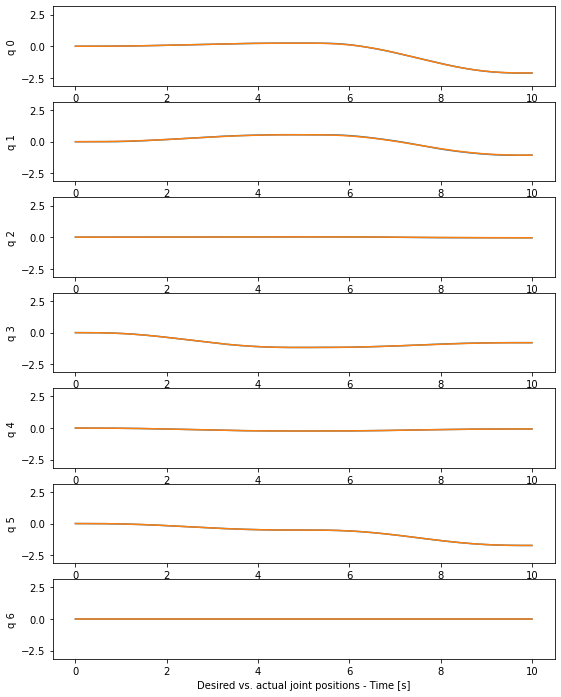

In [68]:
# we plot the simulated vs. actual position of the robot
plt.figure(figsize=[9,12])
for i in range(7):
    plt.subplot(7,1,i+1)
    plt.plot(save_t, save_joint_positions[i,:])
    plt.plot(save_t, save_des_joint_positions[i,:])
    plt.ylim([-np.pi,np.pi])
    plt.ylabel(f'q {i}')
plt.xlabel('Desired vs. actual joint positions - Time [s]')

Text(0.5, 0, 'Desired vs. actual joint velocities - Time [s]')

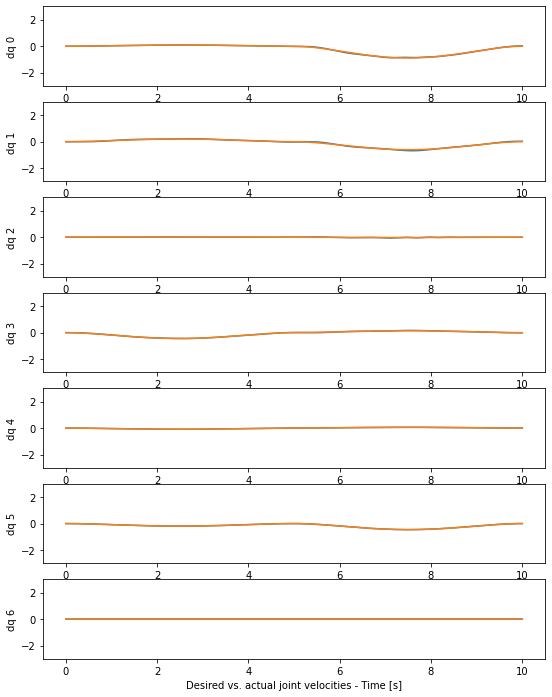

In [69]:
# we plot the simulated vs. actual position of the robot
plt.figure(figsize=[9,12])
for i in range(7):
    plt.subplot(7,1,i+1)
    plt.plot(save_t, save_joint_velocities[i,:])
    plt.plot(save_t, save_des_joint_velocities[i,:])
    plt.ylim([-3,3])
    plt.ylabel(f'dq {i}')
plt.xlabel('Desired vs. actual joint velocities - Time [s]')

## Question 3: End-effector control
As in Question 2, we would like the robot to go from its initial configuration to the desired end-effector positions (in spatial coordinates) $[0.7, 0.2,0.7]$ in 5 seconds and then to the configuration $[0.3, 0.5,0.9]$ during the following 5 seconds.

* Modify the ``robot_controller2`` function below to move the robot from its initial configuration to the first goal (reaching at t=5) and the second goal (t=10) by interpolating the desired end effector positions and directly mapping end-effector error to desired joint velocities (i.e. use P gains equal to 0 in joint space and do resolved-rate control).
* Plot the resulting joint simulated and desired positions and velocities
* Plot the resulting end-effector positions and velocities
* Compare results with Question 2
* Add a nullspace term to optimize a desired configuration of your choice and discuss the results

In [92]:
T = 10.

lambda_coef = 0.01

## this code is to save what the controller is doing for plotting and analysis after the simulation
global save_joint_positions, save_joint_velocities, save_t, ind
global save_des_joint_positions, save_des_joint_velocities
save_joint_positions = np.zeros([7,int(np.ceil(T / 0.001))+1])
save_joint_velocities = np.zeros_like(save_joint_positions)
save_des_joint_positions = np.zeros_like(save_joint_positions)
save_des_joint_velocities = np.zeros_like(save_joint_positions)
save_t = np.zeros([int(np.ceil(T / 0.001))+1])
ind=0
# end of saving code

initial_end_effector_position = np.array([[0], [0],[1.301]])
end_effector_goal1 = np.array([[0.7], [0.2],[0.7]])
end_effector_goal2 = np.array([[0.3], [0.5],[0.9]])

global desired_joint_positions
desired_joint_positions = np.zeros(7)
desired_joint_positions = np.resize(desired_joint_positions, (7, 1))

#     Record of desired endeffector position and actual position
global record_of_desired_end_effector_positions, record_of_actual_end_effector_positions
record_of_desired_end_effector_positions = np.zeros([3, int(np.ceil(T / 0.001))+1])
record_of_actual_end_effector_positions = np.zeros_like(record_of_desired_end_effector_positions)
    
    
def robot_controller2(t, joint_positions, joint_velocities):
    """A typical robot controller
        at every time t, this controller is called by the simulator. It receives as input
        the current joint positions and velocities and needs to return a [7,1] vector
        of desired torque commands
        
        As an example, the current controller implements a PD controller and at time = 5s
        it makes joint 2 and 3 follow sine curves
    """
    
#     Comute new jacobian
    robot.configurations = joint_positions
    robot.forward_kinematics(robot.configurations)
    [rot, trans] = get_rotation_and_translation_from_transform_matrix(robot.get_end_effector_pose())
    jacobian_new = robot.compute_third_frame_jacobian(trans)
    jacobian_x_part = jacobian_new[3:6, :]
    jacobian_pinv = np.matmul(jacobian_x_part.T, np.linalg.inv(np.matmul(jacobian_x_part, jacobian_x_part.T)
                                                               + lambda_coef * np.identity(jacobian_x_part.shape[0])))
    
    
    if t < 5:
        [desired_end_effector_positions, desired_end_effector_velocities] = get_point_to_point_motion(t, 5, initial_end_effector_position, end_effector_goal1)
    else:
        [desired_end_effector_positions, desired_end_effector_velocities] = get_point_to_point_motion(t - 5, 5, end_effector_goal1, end_effector_goal2)
    
    p = np.array([1, 1, 1])
    portion_part = np.diag(10 * p)
    position_error = desired_end_effector_positions - trans
    desired_joint_velocities = np.matmul(jacobian_pinv, desired_end_effector_velocities + np.matmul(portion_part, position_error))
    
    global desired_joint_positions
    desired_joint_positions = desired_joint_positions + 0.001 * desired_joint_velocities
#     desired_joint_positions = np.zeros([7,1])
#     desired_joint_velocities = np.zeros([7,1])
    
    # here we will only use a D controller (i.e. on the desired joint velocities)
    # we increased the D gain for that purpose compared to the previous controller
    D = np.array([4.,4,4,4,4,4,4.])
    
    ##TODO - find the desired joint velocities
    
    desired_joint_torques = np.diag(D) @ (desired_joint_velocities - joint_velocities)
    
    
    ## this code is to save what the controller is doing for plotting and analysis after the simulation
    global save_joint_positions, save_joint_velocities, save_t, ind
    global save_des_joint_positions, save_des_joint_velocities
    save_joint_positions[:,ind] = joint_positions[:,0]
    save_joint_velocities[:,ind] = joint_velocities[:,0]
    save_des_joint_positions[:,ind] = desired_joint_positions[:,0]
    save_des_joint_velocities[:,ind] = desired_joint_velocities[:,0]
    save_t[ind] = t
    
    global record_of_desired_end_effector_positions, record_of_actual_end_effector_positions
    record_of_desired_end_effector_positions[: ,ind] = desired_end_effector_positions[:, 0]
    record_of_actual_end_effector_positions[: ,ind] = trans[:, 0]
    ind += 1
    ## end of saving code
    
    return desired_joint_torques
        
robot_visualizer.display_ball([0.7, 0.2,0.7])
robot_visualizer.simulate_robot(robot_controller2, T=T)

Text(0.5, 0, 'Desired vs. actual joint positions - Time [s]')

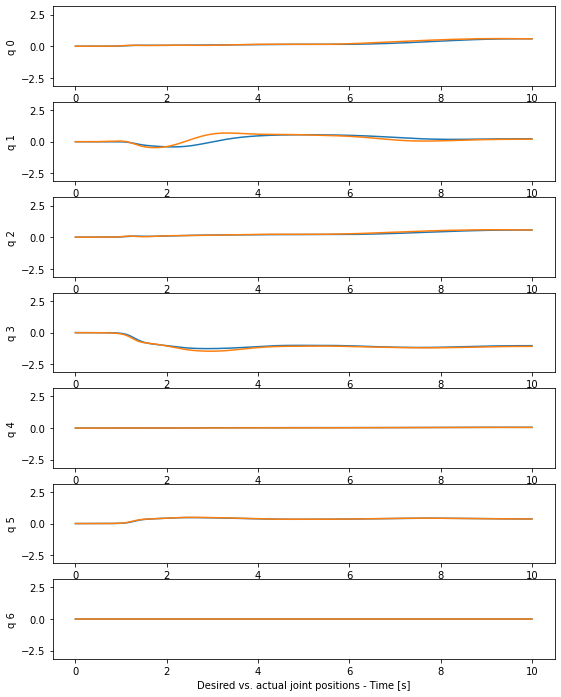

In [93]:
# we plot the simulated vs. actual position of the robot
plt.figure(figsize=[9,12])
for i in range(7):
    plt.subplot(7,1,i+1)
    plt.plot(save_t, save_joint_positions[i,:])
    plt.plot(save_t, save_des_joint_positions[i,:])
    plt.ylim([-np.pi,np.pi])
    plt.ylabel(f'q {i}')
plt.xlabel('Desired vs. actual joint positions - Time [s]')

Text(0.5, 0, 'Desired vs. actual joint velocities - Time [s]')

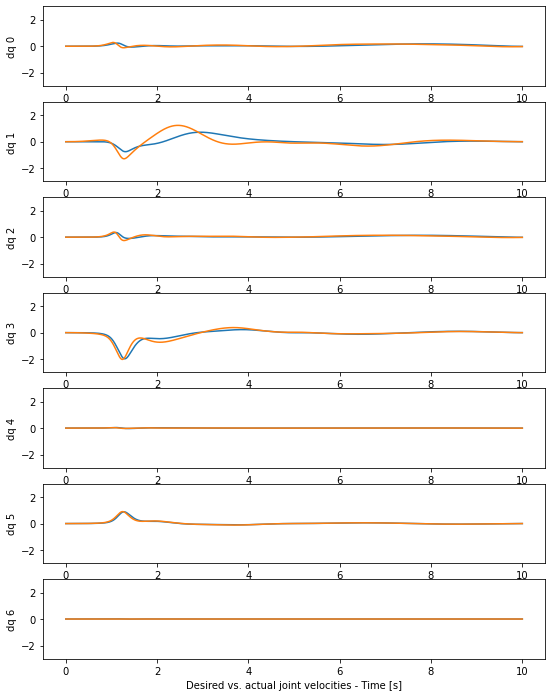

In [94]:
# we plot the simulated vs. actual position of the robot
plt.figure(figsize=[9,12])
for i in range(7):
    plt.subplot(7,1,i+1)
    plt.plot(save_t, save_joint_velocities[i,:])
    plt.plot(save_t, save_des_joint_velocities[i,:])
    plt.ylim([-3,3])
    plt.ylabel(f'dq {i}')
plt.xlabel('Desired vs. actual joint velocities - Time [s]')

Text(0.5, 0, 'Desired vs. actual end-effector positions - Time [s]')

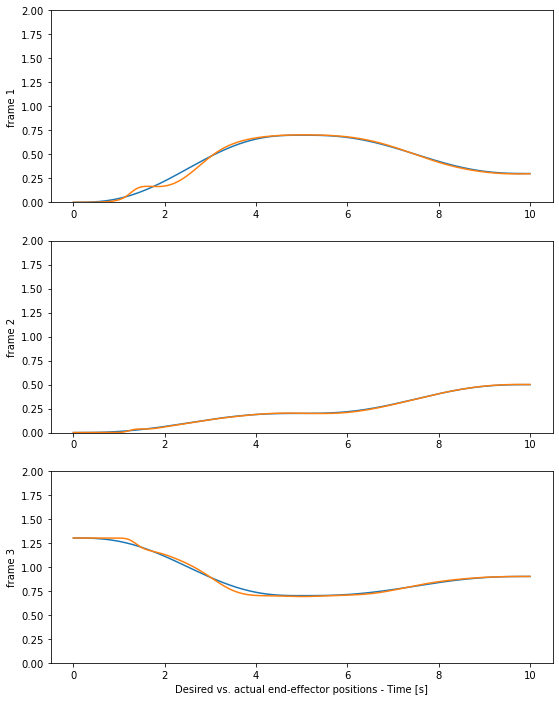

In [97]:
# we plot the simulated vs. actual position of the robot
plt.figure(figsize=[9,12])
for i in range(3):
    plt.subplot(3,1,i+1)
    plt.plot(save_t, record_of_desired_end_effector_positions[i,:])
    plt.plot(save_t, record_of_actual_end_effector_positions[i,:])
    plt.ylim([0,2])
    plt.ylabel(f'frame {i + 1}')
plt.xlabel('Desired vs. actual end-effector positions - Time [s]')